In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate as imrotate
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [3]:
def generate_general_cosine(freq, angle, N=256):
    """
    Generates a cosine image after rotation in a single direction
    freq: cycles (cycles per 2pi)
    angle: rotation angle (degrees)
    """
    t = np.linspace(0, 2*np.pi, N)
    X, Y = np.meshgrid(t, t)

    # 把空間做旋轉座標投影
    theta = np.deg2rad(angle)
    rotated = np.cos(freq * (X*np.cos(theta) + Y*np.sin(theta)))

    return rotated

def generate_composite_and_spectrum(freq1, angle1, freq2=None, angle2=None, combine='sum', N=256,
    apply_mask=False, mask_radius=None, mask_value=0.5, smooth_sigma=None):
    """
    Independent control of rotation and frequency in two directions and mask or smooth.
    """
    base1 = generate_general_cosine(freq1, angle1, N)
    if freq2 is not None:
        base2 = generate_general_cosine(freq2, angle2, N)
    else:
        base2 = np.zeros_like(base1)
    
    if combine == 'single':
        combined = base1
    elif combine == 'sum':
        combined = base1 + base2
    elif combine == 'product':
        combined = base1 * base2
    else:
        raise ValueError("Unknown combine mode")

    image = (combined + 1) / 2

    if apply_mask:
        image = apply_circle_mask(image, radius=mask_radius, A=mask_value)

    if smooth_sigma is not None:
        image = gaussian_filter(image, sigma=smooth_sigma)

    F = np.fft.fftshift(np.fft.fft2(image))
    log_spectrum = np.log(1 + np.abs(F))

    title = f"{combine.capitalize()}: f1={freq1}, a1={angle1}°"
    if freq2 is not None:
        title += f", f2={freq2}, a2={angle2}°"

    return image, log_spectrum, title


In [4]:
def plot_fourier_panel(image1, image2, spectrum1, spectrum2, title1, title2, figsize=(6,6)):
    fig, axs = plt.subplots(2, 2, figsize=figsize)

    axs[0, 0].imshow(image1, cmap='gray')
    axs[0, 0].set_title(title1, fontsize=9)
    axs[0, 0].axis('off')

    axs[0, 1].imshow(image2, cmap='gray')
    axs[0, 1].set_title(title2, fontsize=9)
    axs[0, 1].axis('off')

    axs[1, 0].imshow(spectrum1, cmap='gray')
    axs[1, 0].set_title("Spectrum 1")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(spectrum2, cmap='gray')
    axs[1, 1].set_title("Spectrum 2")
    axs[1, 1].axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

def apply_circle_mask(image, center_x=None, center_y=None, radius=None, A=0.5):
    xnums, ynums = image.shape
    if center_x is None:
        center_x = xnums // 2
    if center_y is None:
        center_y = ynums // 2
    if radius is None:
        radius = min(xnums, ynums) // 2

    Y, X = np.ogrid[:xnums, :ynums]
    mask = (X - center_x)**2 + (Y - center_y)**2 < radius**2
    output = image.copy()
    output[~mask] = A

    return output

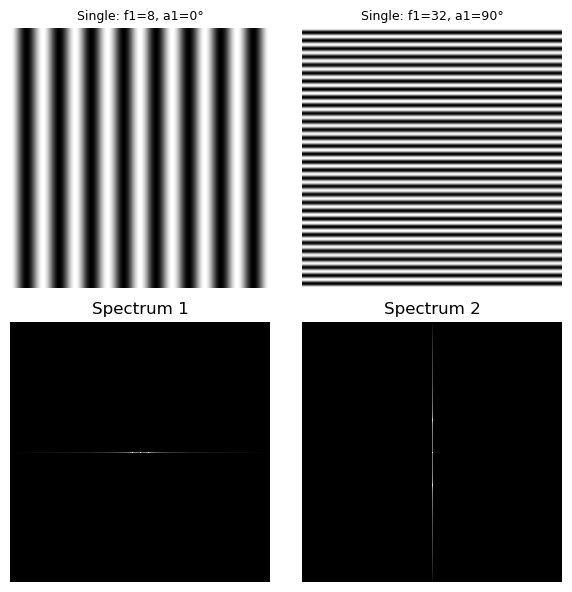

In [5]:
# Horizontal 8 cycles (angle 0)
img1, spec1, title1 = generate_composite_and_spectrum(freq1=8, angle1=0, combine='single')

# Vertical 32 cycles (angle 90)
img2, spec2, title2 = generate_composite_and_spectrum(freq1=32, angle1=90, combine='single')

# plot
plot_fourier_panel(img1, img2, spec1, spec2, title1, title2)

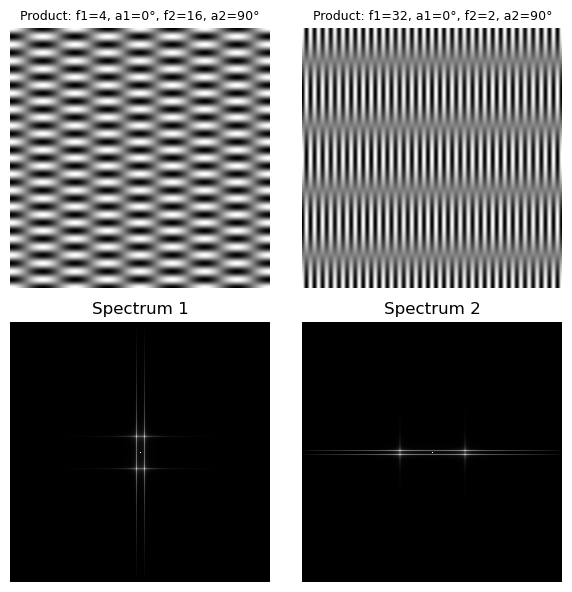

In [6]:
# Horizontal 4 cycles Combine Vertical 16 cycles 
img1, spec1, title1 = generate_composite_and_spectrum(freq1=4, angle1=0, freq2=16, angle2=90, combine='product')

# Horizontal 32 cycles Combine Vertical 2 cycles 
img2, spec2, title2 = generate_composite_and_spectrum(freq1=32, angle1=0, freq2=2, angle2=90, combine='product')

# plot
plot_fourier_panel(img1, img2, spec1, spec2, title1, title2)

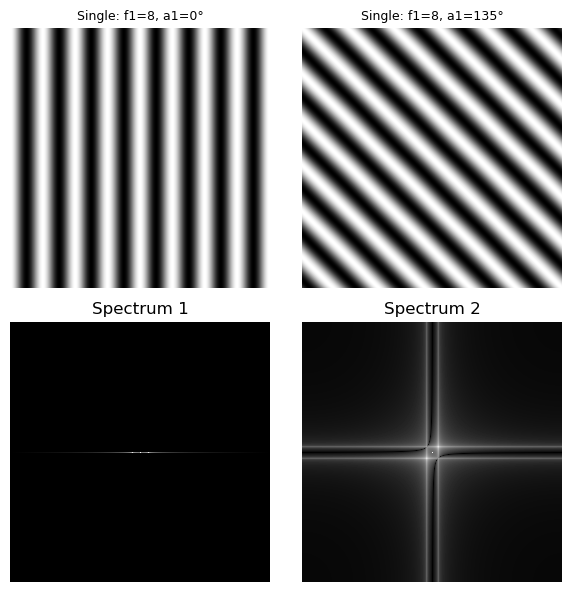

In [7]:
# Horizontal 8 cycles
img1, spec1, title1 = generate_composite_and_spectrum(freq1=8, angle1=0, combine='single')

# Horizontal 8 cycles rotate 135
img2, spec2, title2 = generate_composite_and_spectrum(freq1=8, angle1=135, combine='single')

# plot
plot_fourier_panel(img1, img2, spec1, spec2, title1, title2)

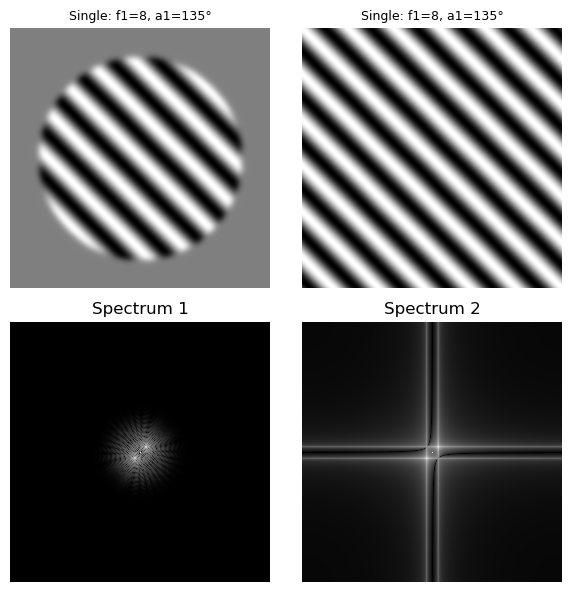

In [8]:
img, spectrum, title = generate_composite_and_spectrum(
    freq1=8, angle1=45, combine='single',
    N=256,
    apply_mask=True, mask_radius=200, mask_value=0.5,
    smooth_sigma=5
)
img1, spec1, title1 = generate_composite_and_spectrum(freq1=8, angle1=135, combine='single', 
                                                       N=256, apply_mask=True, mask_radius=100, mask_value=0.5, smooth_sigma=3)
img2, spec2, title2 = generate_composite_and_spectrum(freq1=8, angle1=135, combine='single', N=256)

plot_fourier_panel(img1, img2, spec1, spec2, title1, title2)


In [9]:
import matplotlib.image as mpimg

In [10]:
def fourier_image_smoothing_demo(filename, sigma=5):
    # 讀取圖像
    img = filename
    
    # 如果為彩色圖像，先轉為灰階
    if img.ndim == 3:
        img = img.mean(axis=2)

    # 水平方向平滑
    smoothed = gaussian_filter1d(img, sigma=sigma, axis=1)

    # 計算 Fourier Transform
    F_1 = np.fft.fftshift(np.fft.fft2(img))
    log_spectrum_1 = np.log(1 + np.abs(F_1))

    F_2 = np.fft.fftshift(np.fft.fft2(smoothed))
    log_spectrum_2 = np.log(1 + np.abs(F_2))

    # 四格繪圖
    fig, axs = plt.subplots(2, 2, figsize=(6,6))

    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Original Image", fontsize=9)
    axs[0, 0].axis('off')

    axs[0, 1].imshow(smoothed, cmap='gray')
    axs[0, 1].set_title(f"Smoothed (sigma={sigma})", fontsize=9)
    axs[0, 1].axis('off')

    axs[1, 0].imshow(log_spectrum_1, cmap='gray')
    axs[1, 0].set_title("Spectrum (Original)")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(log_spectrum_2, cmap='gray')
    axs[1, 1].set_title("Spectrum (Smoothed)")
    axs[1, 1].axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

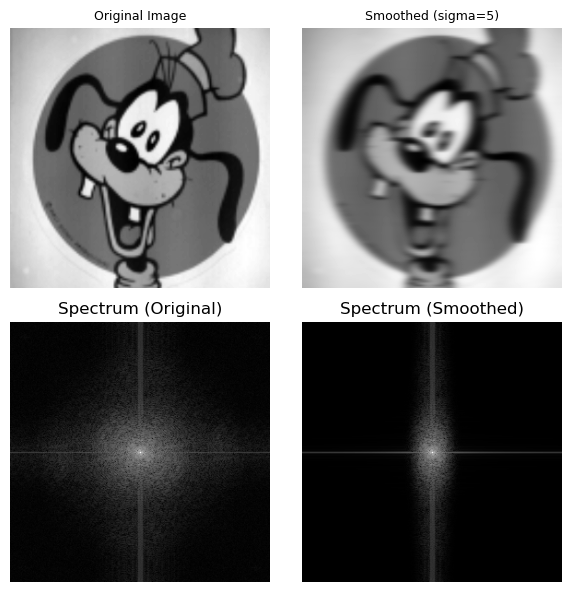

In [11]:
img = mpimg.imread('goofy.png')  
fourier_image_smoothing_demo(img, sigma=5)

In [12]:
def fourier_image_demo(filename1, filename2):
    # 讀取圖像
    img1 = filename1
    img2 = filename2
    # 如果為彩色圖像，先轉為灰階
    if img1.ndim == 3:
        img1 = img1.mean(axis=2)
    if img2.ndim == 3:
        img2 = img2.mean(axis=2)
    # 水平方向平滑

    # 計算 Fourier Transform
    F_1 = np.fft.fftshift(np.fft.fft2(img1))
    log_spectrum_1 = np.log(1 + np.abs(F_1))

    F_2 = np.fft.fftshift(np.fft.fft2(img2))
    log_spectrum_2 = np.log(1 + np.abs(F_2))

    # 四格繪圖
    fig, axs = plt.subplots(2, 2, figsize=(6,6))

    axs[0, 0].imshow(img1, cmap='gray')
    axs[0, 0].set_title("Image1", fontsize=9)
    axs[0, 0].axis('off')

    axs[0, 1].imshow(img2, cmap='gray')
    axs[0, 1].set_title("Image2", fontsize=9)
    axs[0, 1].axis('off')

    axs[1, 0].imshow(log_spectrum_1, cmap='gray')
    axs[1, 0].set_title("Spectrum (Image1)")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(log_spectrum_2, cmap='gray')
    axs[1, 1].set_title("Spectrum (Image2)")
    axs[1, 1].axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()

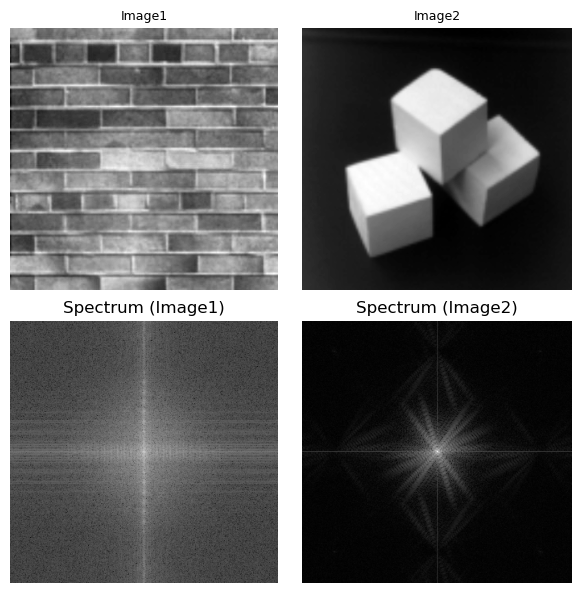

In [13]:
img1 = mpimg.imread('brick.jpeg') 
img2 = mpimg.imread('square.jpeg') 
fourier_image_demo(img1, img2)

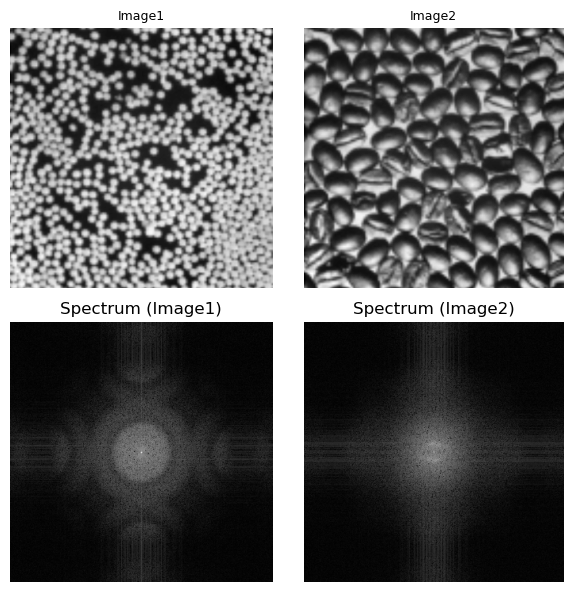

In [14]:
img1 = mpimg.imread('cell.jpg') 
img2 = mpimg.imread('beans.jpg') 
fourier_image_demo(img1, img2)

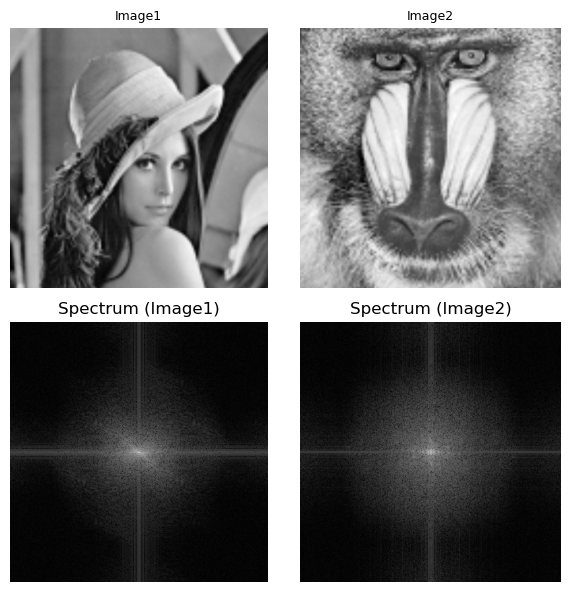

In [15]:
img1 = mpimg.imread('women.jpg') 
img2 = mpimg.imread('baboon.jpg') 
fourier_image_demo(img1, img2)

In [16]:
def ideal_lowpass_filter(F_shift, cutoff):
    """
    Ideal lowpass filter, cutoff is radius.
    """
    N, M = F_shift.shape
    Y, X = np.ogrid[:N, :M]
    center_y, center_x = N//2, M//2
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    mask = distance <= cutoff
    return F_shift * mask

def butterworth_filter(F_shift, cutoff, n=1, type='low'):
    """
    Butterworth lowpass or highpass filter.
    type: 'low' or 'high'
    """
    N, M = F_shift.shape
    Y, X = np.ogrid[:N, :M]
    center_y, center_x = N//2, M//2
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
    distance[distance == 0] = 1e-6 # Preventing 'high' division by zero

    if type == 'low':
        H = 1 / (1 + (distance / cutoff)**(2*n))
    elif type == 'high':
        H = 1 / (1 + (cutoff / distance)**(2*n))
        H[center_y, center_x] = 0  # 避免除以0
    else:
        raise ValueError("type must be 'low' or 'high'")

    return F_shift * H

def high_frequency_emphasis_filter(F_shift, r0=96, gain_low=0.5, gain_high=4.0):
    """
    High-frequency emphasis filter: linearly interpolate gains.
    """
    N, M = F_shift.shape
    Y, X = np.ogrid[:N, :M]
    center_y, center_x = N//2, M//2
    distance = np.sqrt((X - center_x)**2 + (Y - center_y)**2)

    gain = np.piecewise(
        distance,
        [distance <= r0, distance > r0],
        [lambda d: gain_low + (gain_high-gain_low)*(d/r0), gain_high]
    )
    return F_shift * gain


In [17]:
def fourier_filter_demo(filename, filter_type='ideal_low', cutoff=50, n=1, emphasis_params=None):
    """
    Fourier domain filtering demo.
    
    filter_type: 'ideal_low', 'butter_low', 'butter_high', 'emphasis'
    """
    img = filename
    if img.ndim == 3:
        img = img.mean(axis=2)
    
    # FFT and shift
    F = np.fft.fft2(img)
    F_shift = np.fft.fftshift(F)

    # Apply filters
    if filter_type == 'ideal_low':
        F_filtered = ideal_lowpass_filter(F_shift, cutoff)
    elif filter_type == 'butter_low':
        F_filtered = butterworth_filter(F_shift, cutoff, n=n, type='low')
    elif filter_type == 'butter_high':
        F_filtered = butterworth_filter(F_shift, cutoff, n=n, type='high')
    elif filter_type == 'emphasis':
        if emphasis_params is None:
            emphasis_params = {'r0': 127, 'gain_low': 1, 'gain_high': 4.0}
        F_filtered = high_frequency_emphasis_filter(F_shift, **emphasis_params)
    else:
        raise ValueError("Unknown filter type.")
    
    # IFFT
    img_filtered = np.fft.ifft2(np.fft.ifftshift(F_filtered))
    img_filtered = np.abs(img_filtered)

    # Spectrums
    log_spectrum = np.log(1 + np.abs(F_shift))
    log_spectrum_filtered = np.log(1 + np.abs(F_filtered))

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(6,6))

    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(img_filtered, cmap='gray')
    axs[0, 1].set_title(f"Filtered: {filter_type}")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(log_spectrum, cmap='gray')
    axs[1, 0].set_title("Original Spectrum")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(log_spectrum_filtered, cmap='gray')
    axs[1, 1].set_title("Filtered Spectrum")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()


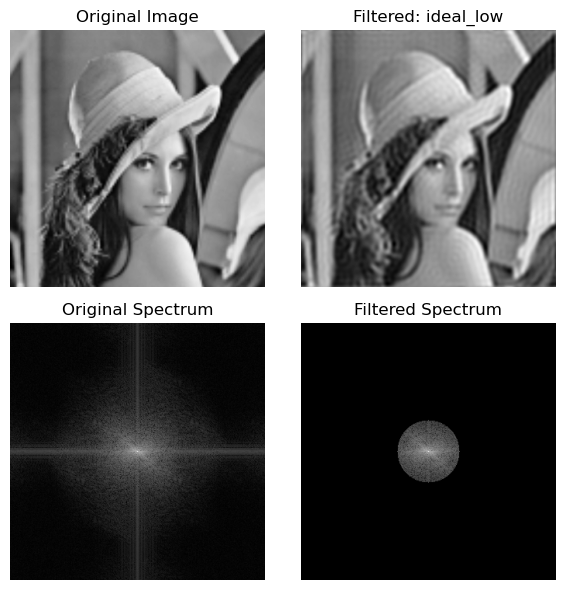

In [18]:
img = mpimg.imread('women.jpg') 
fourier_filter_demo(img, filter_type='ideal_low', cutoff=40)

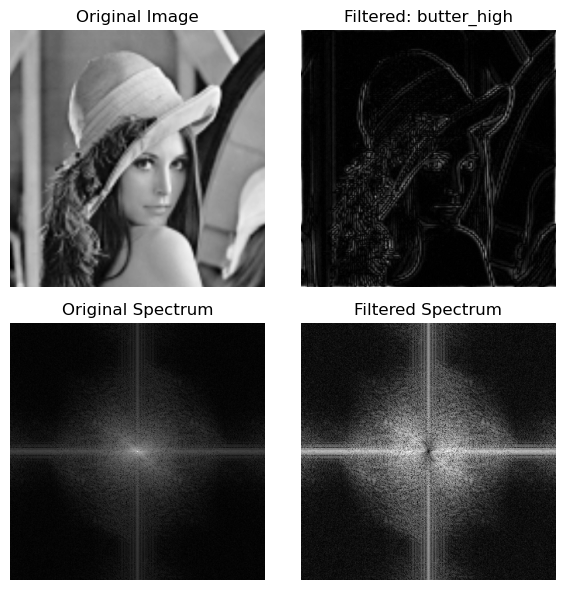

In [19]:
img = mpimg.imread('women.jpg') 
fourier_filter_demo(img, filter_type='butter_high', cutoff=50)

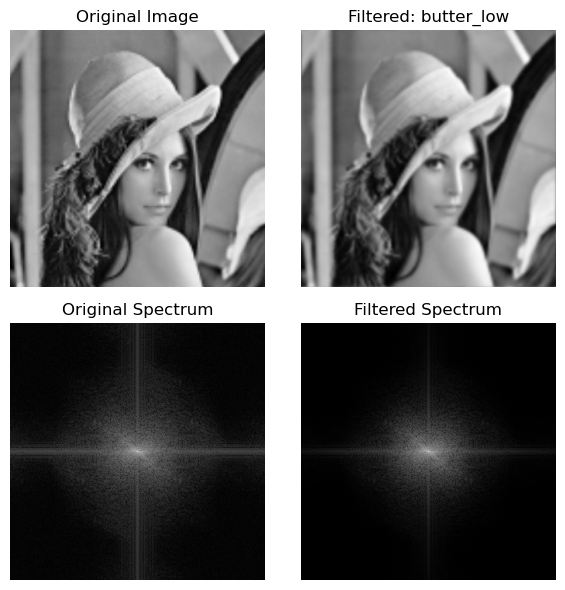

In [20]:
img = mpimg.imread('women.jpg') 
fourier_filter_demo(img, filter_type='butter_low', cutoff=50)

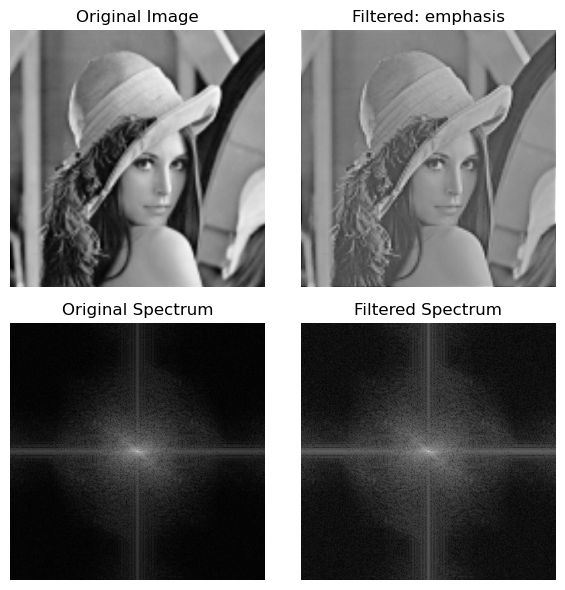

In [21]:
img = mpimg.imread('women.jpg') 
fourier_filter_demo(img, filter_type='emphasis')